# Data Import

In [26]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Import te data: 

In [27]:
import json
import os
from pathlib import Path

yearly_dir = Path('data/pushshift/yearly')
all_data = []

for file_path in sorted(yearly_dir.glob('AmItheAsshole_submissions_*.txt')):
    print(f"Loading {file_path.name}...")
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                record = json.loads(line)
                all_data.append({
                    'link_flair_text': record.get('link_flair_text'),
                    'selftext': record.get('selftext'),
                    'title': record.get('title')
                })
            except json.JSONDecodeError:
                continue

df = pd.DataFrame(all_data)
print(f"\nLoaded {len(df)} records")
print(f"Columns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")


Loading AmItheAsshole_submissions_2013.txt...
Loading AmItheAsshole_submissions_2014.txt...
Loading AmItheAsshole_submissions_2015.txt...
Loading AmItheAsshole_submissions_2016.txt...
Loading AmItheAsshole_submissions_2017.txt...
Loading AmItheAsshole_submissions_2018.txt...
Loading AmItheAsshole_submissions_2019.txt...
Loading AmItheAsshole_submissions_2020.txt...
Loading AmItheAsshole_submissions_2021.txt...
Loading AmItheAsshole_submissions_2022.txt...
Loading AmItheAsshole_submissions_2023.txt...
Loading AmItheAsshole_submissions_2024.txt...

Loaded 597967 records
Columns: ['link_flair_text', 'selftext', 'title']
Shape: (597967, 3)


Some of the post have beeen "deleted" so there's need to filter them out

In [28]:
print("=" * 80)
print("FILTERING OUT DELETED POSTS")
print("=" * 80)

print(f"\nBefore filtering:")
print(f"Total samples: {len(df)}")
deleted_count = (df['selftext'] == '[deleted]').sum()
print(f"Samples with selftext='[deleted]': {deleted_count}")

df = df[df['selftext'] != '[deleted]'].copy()

print(f"\nAfter filtering:")
print(f"Total samples: {len(df)}")
print(f"Removed {deleted_count} samples with '[deleted]' selftext")

print("\n" + "-" * 80)

FILTERING OUT DELETED POSTS

Before filtering:
Total samples: 597967
Samples with selftext='[deleted]': 75584

After filtering:
Total samples: 522383
Removed 75584 samples with '[deleted]' selftext

--------------------------------------------------------------------------------


it turned out the older posts have different versions of the tags

LINK_FLAIR_TEXT STATISTICS

Total number of samples: 522383
Number of samples with link_flair_text: 522383
Number of samples with missing link_flair_text: 0

--------------------------------------------------------------------------------
Link Flair Text Distribution:
--------------------------------------------------------------------------------
link_flair_text
Not the A-hole                    409455
Asshole                           106413
not the a-hole                      4207
asshole                             1545
not the asshole                      403
                                   ...  
Asshole &amp; Shitpost                 1
Asshole (maybe)                        1
Fake | Asshole                         1
Rule Evading Asshole Supreme           1
Crouching Liar; hidden asshole         1
Name: count, Length: 153, dtype: int64

--------------------------------------------------------------------------------
Link Flair Text Distribution (Percentages):
------------------

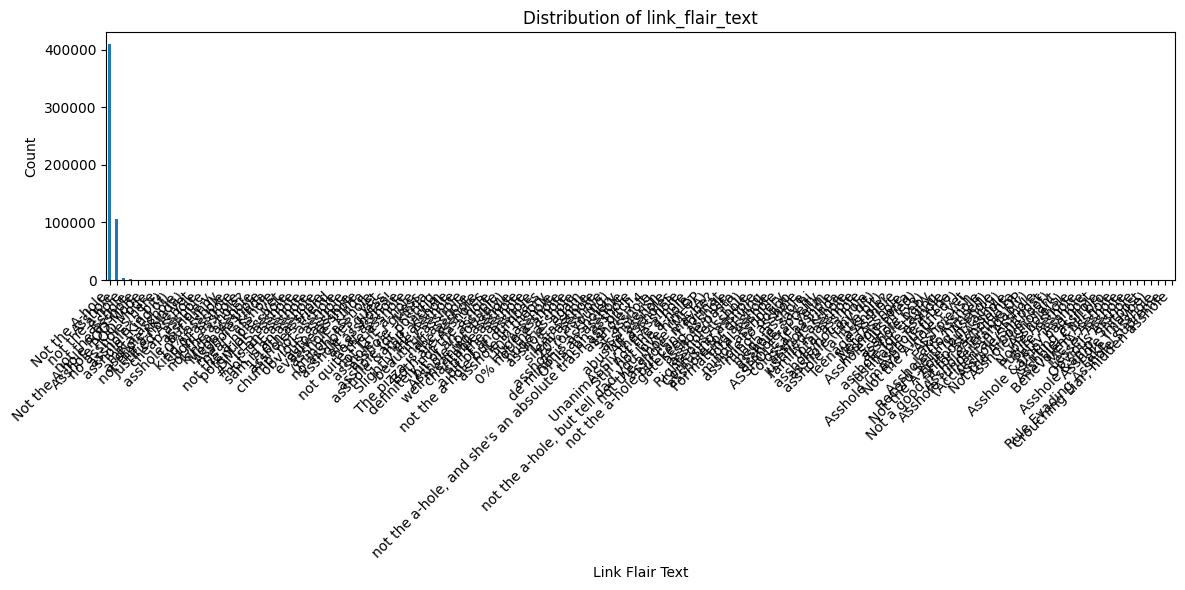

In [29]:
print("=" * 80)
print("LINK_FLAIR_TEXT STATISTICS")
print("=" * 80)

print(f"\nTotal number of samples: {len(df)}")
print(f"Number of samples with link_flair_text: {df['link_flair_text'].notna().sum()}")
print(f"Number of samples with missing link_flair_text: {df['link_flair_text'].isna().sum()}")

print("\n" + "-" * 80)
print("Link Flair Text Distribution:")
print("-" * 80)
flair_counts = df['link_flair_text'].value_counts()
print(flair_counts)

print("\n" + "-" * 80)
print("Link Flair Text Distribution (Percentages):")
print("-" * 80)
flair_percentages = df['link_flair_text'].value_counts(normalize=True) * 100
for flair, pct in flair_percentages.items():
    print(f"{flair}: {pct:.2f}%")

print("\n" + "-" * 80)
print("Visualization:")
print("-" * 80)
plt.figure(figsize=(12, 6))
flair_counts.plot(kind='bar')
plt.title('Distribution of link_flair_text')
plt.xlabel('Link Flair Text')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The function to categorize all of them into a binary category

BINARY LINK_FLAIR_TEXT TRANSFORMATION

Samples successfully transformed: 522383
Samples that could not be transformed: 0

--------------------------------------------------------------------------------
Binary Link Flair Text Distribution:
--------------------------------------------------------------------------------
link_flair_text
not a-hole    414214
a-hole        108169
Name: count, dtype: int64

--------------------------------------------------------------------------------
Binary Link Flair Text Distribution (Percentages):
--------------------------------------------------------------------------------
not a-hole: 79.29%
a-hole: 20.71%

--------------------------------------------------------------------------------
Visualization:
--------------------------------------------------------------------------------


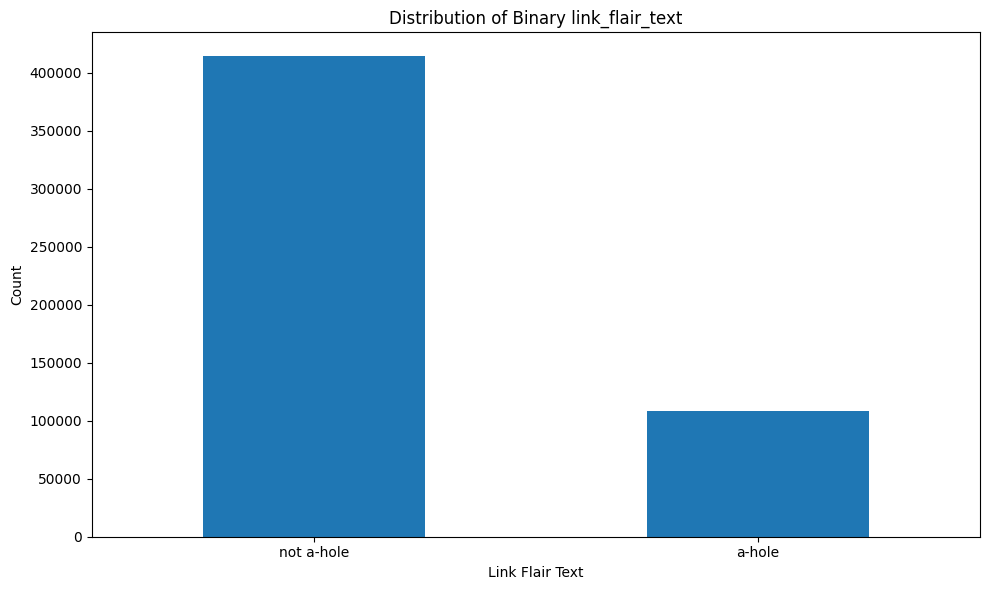

In [30]:
def transform_to_binary_flair(flair_text):
    """
    Transform link_flair_text into binary categories: 'not a-hole' or 'a-hole'.
    
    Args:
        flair_text: Original link_flair_text value
    
    Returns:
        Binary category: 'not a-hole' or 'a-hole'
    """
    if pd.isna(flair_text):
        return None
    
    flair_lower = str(flair_text).lower()
    
    not_ahole_keywords = ['not the a-hole', 'not the asshole', 
                          'not the a-hole poo mode', 'no assholes here', 'not the a-hole?', 
                          'not the a-hole yet', 'still not the a-hole', 'not the a-hole-', 
                          "not the a-hole but can't format", 'definitely not the a-hole', 
                          'not the asshole', 'not quite the asshole', 'chump, not asshole', 
                          'no assholes - yet', 'not the a-hole!', '0% not the a-hole', 'not the a-hole (meta)', 
                          'not the a-hole...yet', "not the a-hole, and she's an absolute trash ass bitch.", 
                          'not the a-hole but dumbass', 'not the a-hole', 'not the a-hole, but tell dad you love him op', 
                          'not the a-hole (but tacky)', 'not the a-hole (oof)', 'not a good fit for asshole/nta', 'not the a-hole... yet']

    ahole_keywords = ['asshole', 'asshole poo mode', 'asshole (a bit)', 'asshole (kind of)', 
                      'asshole (kinda)', 'meta-asshole', 'justified asshole', 'asshole for posting', 
                      'slight asshole', 'kind of asshole', 'asshole-y', 'cheap asshole', 'asshole, but funny', 
                      'mega asshole', 'meta asshole', 'asshole kinda', '10% asshole', 'kinda asshole', 'asshole-ish', 
                      'all assholes!', 'evasive asshole', 'asshole - i guess', 'asshole, kinda', '"near" asshole',
                      'unanimassly the asshole', 'all assholes', 'asshole, maybe?', 'both are assholes', 
                      'bit of an asshole', 'half-asshole', 'dm;hs asshole', 
                      'potential asshole', '#1 is an asshole', '(minor) asshole', 'obvious asshole', "asshole's friend", 
                      'auto-asshole', 'a bit of an asshole', 'kinda asshole', 'still the asshole', 'asshole for even posting this', 
                      'asshole in theory', '50%asshole', 'asshole - kinda', 'beautiful asshole', 'asshole ...i guess', 'huge asshole',
                      'silent asshole', 'charitable asshole', 'asshole, again', 'huge asshole', 'abusive asshole',
                      'op is an asshole', 'asshole x 4', 'sf asshole', 'total asshole', '1/3 asshole', 'formatting asshole', 'asshole for driving', 
                      'asshole; marry him', 'asshole per se', 'righteous asshole', 'asshole/pasta', 'confusing asshole', 'asshole (or young)', 
                      'asshole (probably)', 'well meaning asshole', 'slightly the asshole', 'half asshole', 'asshole baby', 'asshole, say hi', 
                      'colossal asshole', 'asshole fer yellin', 'asshole soceity', 'gatekeep asshole', 'family is asshole', 'justified asshole', 
                      'asshole kinda', 'justifiable asshole', 'mega-asshole', 'asshole (x3)', 'asshole to doggo', 'minor assholery', 'asshole (tiny bit)', 
                      'asshole (a little bit)', 'asshole desu', 'teenage asshole', 'metaasshole', 'asshole sorta', 'asshole (justified)', 'asshole-ish', 
                      'asshole (maybe justified?)', 'asshole?', 'total asshole', '8 assholes!', 'asshole and thief', 'minor asshole', 'record setting asshole', 
                      'asshole (to himself)', 'fake asshole', 'asshole if true', '(accidental) asshole', 'asshole/shitpost', 'mild asshole', 'asshole/terrible op', 
                      'asshole (understandably)', 'future asshole', 'petty asshole', 'asshole/ignorant', 'shitpost/asshole', 'asshole; chill bro', 'skirting asshole', 
                      'asshole(s)', 'noble asshole', 'lesser asshole', 'benevolent asshole', 'obvious asshole', 'tl;dr, asshole', 'asshole (but funny/justified)']
    

    
    for keyword in not_ahole_keywords:
        if keyword in flair_lower:
            return 'not a-hole'
    
    for keyword in ahole_keywords:
        if keyword in flair_lower:
            return 'a-hole'
    
    return None

df['link_flair_text_original'] = df['link_flair_text'].copy()
df['link_flair_text'] = df['link_flair_text'].apply(transform_to_binary_flair)

print("=" * 80)
print("BINARY LINK_FLAIR_TEXT TRANSFORMATION")
print("=" * 80)

print(f"\nSamples successfully transformed: {df['link_flair_text'].notna().sum()}")
print(f"Samples that could not be transformed: {df['link_flair_text'].isna().sum()}")

print("\n" + "-" * 80)
print("Binary Link Flair Text Distribution:")
print("-" * 80)
binary_counts = df['link_flair_text'].value_counts()
print(binary_counts)

print("\n" + "-" * 80)
print("Binary Link Flair Text Distribution (Percentages):")
print("-" * 80)
binary_percentages = df['link_flair_text'].value_counts(normalize=True) * 100
for flair, pct in binary_percentages.items():
    print(f"{flair}: {pct:.2f}%")

print("\n" + "-" * 80)
print("Visualization:")
print("-" * 80)
plt.figure(figsize=(10, 6))
binary_counts.plot(kind='bar')
plt.title('Distribution of Binary link_flair_text')
plt.xlabel('Link Flair Text')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


As we have more then enough data we can afford to downsample it

DOWNSAMPLING TO BALANCE LABELS

Before downsampling:
link_flair_text
not a-hole    414214
a-hole        108169
Name: count, dtype: int64
Total samples: 522383

Minimum class size: 54084

After downsampling:
link_flair_text
a-hole        54084
not a-hole    54084
Name: count, dtype: int64
Total samples: 108168

--------------------------------------------------------------------------------
Visualization:
--------------------------------------------------------------------------------


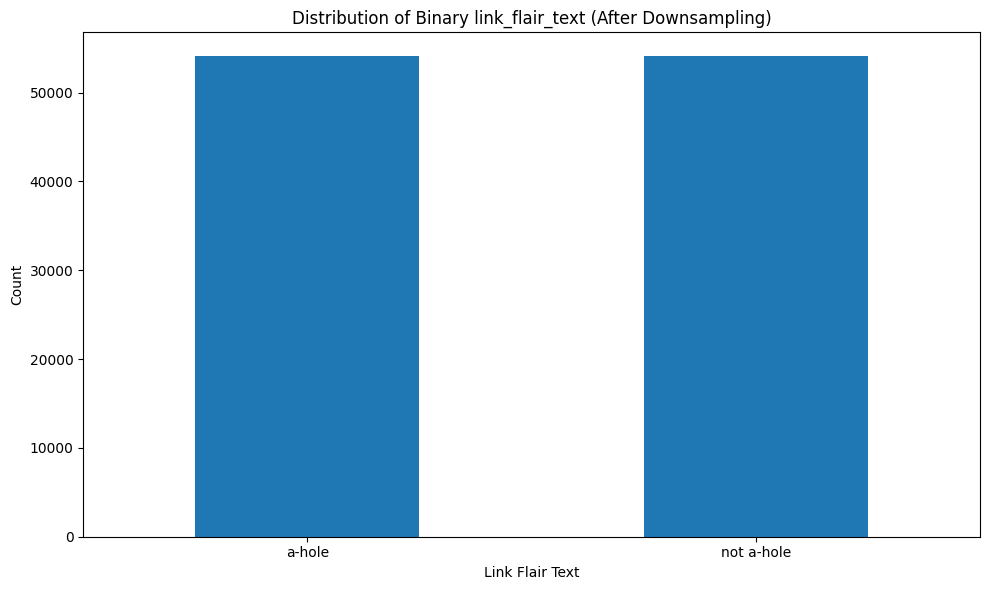

In [31]:
print("=" * 80)
print("DOWNSAMPLING TO BALANCE LABELS")
print("=" * 80)

print(f"\nBefore downsampling:")
print(df['link_flair_text'].value_counts())
print(f"Total samples: {len(df)}")

min_class_size = int(df['link_flair_text'].value_counts().min() / 2) #To decrese he number even more
print(f"\nMinimum class size: {min_class_size}")

df_downsampled = df.groupby('link_flair_text', group_keys=False).apply(
    lambda x: x.sample(n=min_class_size, random_state=42) if len(x) > min_class_size else x
).reset_index(drop=True)

print(f"\nAfter downsampling:")
print(df_downsampled['link_flair_text'].value_counts())
print(f"Total samples: {len(df_downsampled)}")

df = df_downsampled.copy()

print("\n" + "-" * 80)
print("Visualization:")
print("-" * 80)
plt.figure(figsize=(10, 6))
df['link_flair_text'].value_counts().plot(kind='bar')
plt.title('Distribution of Binary link_flair_text (After Downsampling)')
plt.xlabel('Link Flair Text')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Text Preprocessing

In [32]:
import contractions
import re

def expand_contractions(text):
    """Expand contractions like don't -> do not, I'm -> I am, etc."""
    if not isinstance(text, str):
        return ""
    return contractions.fix(text)

def remove_urls_and_mentions(text):
    """Remove URLs, email addresses, and @mentions."""
    if not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    # Remove @mentions
    text = re.sub(r'@\S+', ' ', text)
    return text

def remove_html_entities(text):
    """Remove HTML entities like &amp;, &lt;, etc."""
    if not isinstance(text, str):
        return ""
    return re.sub(r'&\w+;', ' ', text)
    
def remove_special_characters(text, keep_sentence_structure=True):
    """
    Remove special characters but optionally keep sentence structure.
    
    Args:
        text: Input text
        keep_sentence_structure: If True, keep periods, commas, question marks, etc.
    """
    if not isinstance(text, str):
        return ""
        
    if keep_sentence_structure:
        # Keep sentence structure but remove other special characters
        text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)
    else:
        # Remove all non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    return text

def normalize_whitespace(text):
    """Normalize whitespace by removing extra spaces."""
    if not isinstance(text, str):
        return ""
    return re.sub(r'\s+', ' ', text).strip()

def transform_age_gender_patterns(text):
    """
    Transform age/gender patterns like '23f', '45m' into '23 years old female', '45 years old male'.
    
    Args:
        text: Input text
    
    Returns:
        Text with age/gender patterns transformed
    """
    if not isinstance(text, str):
        return ""
    
    def replace_pattern(match):
        age = match.group(1)
        gender_char = match.group(2).lower()
        
        if gender_char == 'f':
            return f"{age} years old female"
        elif gender_char == 'm':
            return f"{age} years old male"
        else:
            return match.group(0)
    
    pattern = r'\b(\d{1,3})([fmFM])\b'
    text = re.sub(pattern, replace_pattern, text)
    
    return text

def handle_possessives(text):
    """
    Handle possessive forms before removing apostrophes.
    Converts "Mom's" -> "Mom", "John's" -> "John" etc.
    This prevents leftover 's' characters after apostrophe removal.
    
    Args:
        text: Input text
    
    Returns:
        Text with possessive apostrophes removed
    """
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r"(\w+)'s\b", r'\1', text)
    text = re.sub(r"(\w+)s'\b", r'\1s', text)
    
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts."""
    from nltk.corpus import wordnet
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text, lemmatizer):
    """
    Lemmatize words in text using WordNet lemmatizer.
    
    Args:
        text: Input text string
        lemmatizer: WordNetLemmatizer instance
    
    Returns:
        Lemmatized text string
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    
    try:
        words = word_tokenize(text)
        lemmatized_words = []
        for word in words:
            pos = get_wordnet_pos(word)
            lemmatized_word = lemmatizer.lemmatize(word.lower(), pos)
            lemmatized_words.append(lemmatized_word)
        return ' '.join(lemmatized_words)
    except:
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
        return ' '.join(lemmatized_words)


In [33]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

ENGLISH_STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/ek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ek/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


According to the recomendations to BertTopic the special characters were deleted, along the other reddit-specific modificaions. 
! Lemmanization was turned off as there wasn't any substantial improvements in the performance

In [34]:
def preprocess_text(text, 
                   expand_contractions_flag=True,
                   remove_urls_flag=True,
                   remove_html_flag=True,
                   remove_special_chars_flag=True,
                   keep_sentence_structure=False,
                   remove_stopwords_flag=True,
                   lemmatize_flag=True,
                   transform_age_gender_flag=True,
                   handle_possessives_flag=True,
                   custom_stopwords=None,
                   lowercase_flag=True):
    """
    Comprehensive text preprocessing pipeline.
    
    Args:
        text: Input text
        expand_contractions_flag: Whether to expand contractions
        remove_urls_flag: Whether to remove URLs, emails, and mentions
        remove_html_flag: Whether to remove HTML entities
        remove_special_chars_flag: Whether to remove special characters
        keep_sentence_structure: Whether to keep sentence structure punctuation
        remove_stopwords_flag: Whether to remove stopwords
        lemmatize_flag: Whether to lemmatize words
        transform_age_gender_flag: Whether to transform age/gender patterns (e.g., '23f' -> '23 years old female')
        handle_possessives_flag: Whether to handle possessive forms (e.g., "Mom's" -> "Mom")
        custom_stopwords: Additional stopwords to remove
        lowercase_flag: Whether to convert to lowercase
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase if specified
    if lowercase_flag:
        text = text.lower()
    
    # Handle possessives before removing special characters
    if handle_possessives_flag:
        text = handle_possessives(text)
    
    # Transform age/gender patterns before removing special characters
    if transform_age_gender_flag:
        text = transform_age_gender_patterns(text)
    
    # Apply preprocessing steps based on flags
    if expand_contractions_flag:
        text = expand_contractions(text)
    
    if remove_urls_flag:
        text = remove_urls_and_mentions(text)
    
    if remove_html_flag:
        text = remove_html_entities(text)
    
    # Remove specific AITA-related terms that might skew analysis
    text = re.sub(r'\b(aita|yta|nta|esh|nah|info)\b', ' ', text, flags=re.IGNORECASE)
    
    if remove_special_chars_flag:
        text = remove_special_characters(text, keep_sentence_structure)

    
    # Remove stopwords
    if remove_stopwords_flag:
        stopwords_set = set(ENGLISH_STOP_WORDS)
        if custom_stopwords:
            stopwords_set.update([word.lower() for word in custom_stopwords])
        words = text.split()
        text = ' '.join([word for word in words if word not in stopwords_set])
    
    # Lemmatize words
    if lemmatize_flag:
        text = lemmatize_text(text, lemmatizer)
    
    # Final whitespace normalization
    text = normalize_whitespace(text)
    
    return text



custom_stopwords = ['aita', 'reddit', 'subreddit', 'upvote', 'downvote', 'karma']

df["combined_text"] = df["title"].fillna("") + " " + df["selftext"].fillna("")
df["clean_text"] = df["combined_text"].apply(lambda x: preprocess_text(
    x,
    expand_contractions_flag=True,
    remove_urls_flag=True,
    remove_html_flag=True,
    remove_special_chars_flag=True,
    keep_sentence_structure=False,
    remove_stopwords_flag=True,
    lemmatize_flag=False,
    transform_age_gender_flag=True,
    handle_possessives_flag=True,
    custom_stopwords=custom_stopwords,
    lowercase_flag=True
))

# Display the results
df[["title", "selftext", "combined_text", "clean_text"]].head()

,title,selftext,combined_text,clean_text
0,AITA [43M] for giving my daughter [20F] a curfew?,"I have 3 kids, 2 boys and 1 girl. I treat them...",AITA [43M] for giving my daughter [20F] a curf...,43 years old male giving daughter 20 years old...
1,AITA for calling my wifes way of eating backwa...,"title is her words, so maybe misleading since ...",AITA for calling my wifes way of eating backwa...,calling wifes way eating backwards undermining...
2,AITA For telling my one friend I couldn’t play...,I was playing Fortnite (yes it’s cringe but I ...,AITA For telling my one friend I couldn’t play...,telling one friend could play really full team...
3,AITA for talking about my brother's kitten?,My brother used to have a kitten he had to put...,AITA for talking about my brother's kitten? My...,talking brother kitten brother used kitten put...
4,AITA for asking my daughter to pick a differen...,"My \[F, 48\] daughter who I'll call M \[F, 23\...",AITA for asking my daughter to pick a differen...,asking daughter pick different wedding date f ...


Train/test split with sratification

In [35]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['link_flair_text'] if df['link_flair_text'].notna().sum() > 0 else None
)

print(f"Train set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")
print(f"\nTrain link_flair_text distribution:")
print(df_train['link_flair_text'].value_counts())
print(f"\nTest link_flair_text distribution:")
print(df_test['link_flair_text'].value_counts())


Train set size: 86534
Test set size: 21634

Train link_flair_text distribution:
link_flair_text
a-hole        43267
not a-hole    43267
Name: count, dtype: int64

Test link_flair_text distribution:
link_flair_text
not a-hole    10817
a-hole        10817
Name: count, dtype: int64


# Text Clustering 

In [36]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import plotly.express as px

The implementation of BertTopic itself, if the model is already present in the folder it will use the existing one. Time and computationally expensve! 

![alt text](https://bertopic.com/wp-content/uploads/2025/07/bertopic.webp)

source: https://bertopic.com/

## Train

In [38]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
import os

model_path = "Bertopic_model_save"

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}...")
    topic_model = BERTopic.load(model_path)
    docs_train = df_train['clean_text'].tolist()
    topics_train, probs_train = topic_model.transform(docs_train)
    print("Model loaded successfully!")
else:
    print(f"Model not found at {model_path}. Creating new model...")
    representation_model = MaximalMarginalRelevance(diversity=0.2)
    
    topic_model = BERTopic(
        embedding_model=embedding_model,
        representation_model=representation_model,
        language='english',
        calculate_probabilities=True,
        verbose=True
    )
    
    docs_train = df_train['clean_text'].tolist()
    topics_train, probs_train = topic_model.fit_transform(docs_train)


2026-01-15 18:22:25,928 - BERTopic - Embedding - Transforming documents to embeddings.


Model not found at Bertopic_model_save. Creating new model...


Batches: 100%|██████████| 2705/2705 [01:44<00:00, 25.95it/s] 
2026-01-15 18:24:12,308 - BERTopic - Embedding - Completed ✓
2026-01-15 18:24:12,311 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-15 18:24:26,216 - BERTopic - Dimensionality - Completed ✓
2026-01-15 18:24:26,218 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-15 18:31:50,440 - BERTopic - Cluster - Completed ✓
2026-01-15 18:31:50,450 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-15 18:31:57,959 - BERTopic - Representation - Completed ✓


Initally it clusters with a lot of outliers, so this is implemented to force it to classify them:

In [ ]:
if os.path.exists(model_path):
    print('Outlier Reduction has already been performed!')

else:
    print("=" * 80)
    print("OUTLIER REDUCTION")
    print("=" * 80)

    print(f"\nInitial number of outliers: {topics_train.count(-1)}")
    print(f"Initial number of topics: {len(set(topics_train)) - (1 if -1 in topics_train else 0)}")

    print("\nReducing outliers using multiple strategies...")
    print("\nStep 1: Using 'c-tf-idf' strategy (fast, good initial reduction)...")
    topics_train_reduced = topic_model.reduce_outliers(
        docs_train, 
        topics_train, 
        strategy="c-tf-idf",
        threshold=0.1
    )

    print(f"After c-tf-idf strategy - Outliers: {topics_train_reduced.count(-1)}")

    print("\nStep 2: Using 'probabilities' strategy (for remaining outliers)...")
    topics_train_reduced = topic_model.reduce_outliers(
        docs_train, 
        topics_train_reduced, 
        probabilities=probs_train,
        strategy="probabilities",
        threshold=0.05
    )

    print(f"After probabilities strategy - Outliers: {topics_train_reduced.count(-1)}")

    print("\nStep 3: Using 'embeddings' strategy (for final outliers)...")
    print("Computing embeddings for outlier reduction...")
    embeddings_for_reduction = embedding_model.encode(docs_train, show_progress_bar=True, batch_size=32)

    topics_train_reduced = topic_model.reduce_outliers(
        docs_train, 
        topics_train_reduced,
        embeddings=embeddings_for_reduction,
        strategy="embeddings",
        threshold=0.3
    )

    final_outliers = topics_train_reduced.count(-1)
    final_topics = len(set(topics_train_reduced)) - (1 if -1 in topics_train_reduced else 0)

    print(f"\nFinal number of outliers: {final_outliers}")
    print(f"Final number of topics: {final_topics}")
    print(f"Outliers reduced by: {topics_train.count(-1) - final_outliers} ({((topics_train.count(-1) - final_outliers) / topics_train.count(-1) * 100):.1f}%)")

    print("\nUpdating topic model with reduced outliers...")
    topic_model.update_topics(docs_train, topics=topics_train_reduced)

    topics_train = topics_train_reduced
    print("\nOutlier reduction completed!")


OUTLIER REDUCTION

Initial number of outliers: 46838
Initial number of topics: 362

Reducing outliers using multiple strategies...

Step 1: Using 'c-tf-idf' strategy (fast, good initial reduction)...
After c-tf-idf strategy - Outliers: 2653

Step 2: Using 'probabilities' strategy (for remaining outliers)...
After probabilities strategy - Outliers: 2518

Step 3: Using 'embeddings' strategy (for final outliers)...
Computing embeddings for outlier reduction...


Batches: 100%|██████████| 2705/2705 [01:42<00:00, 26.34it/s] 
2026-01-15 18:33:50,395 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Final number of outliers: 6
Final number of topics: 362
Outliers reduced by: 46832 (100.0%)

Updating topic model with reduced outliers...

Outlier reduction completed!


Final topics:

In [40]:
df_train['topic'] = topics_train
#df_train['topic_probability'] = probs_train

print(f"Number of training documents: {len(docs_train)}")
print(f"Number of topics found: {len(set(topics_train)) - (1 if -1 in topics_train else 0)}")
print(f"Number of outliers: {topics_train.count(-1)}")

topic_info = topic_model.get_topic_info()
print("\nTopic Information:")
print(topic_info.head(10))

Number of training documents: 86534
Number of topics found: 362
Number of outliers: 6

Topic Information:
   Topic  Count                                      Name  \
0     -1      6  -1_bechdel_partisan_extremism_usefulness   
1      0   2502       0_removed_telling_refusing_daughter   
2      1   4952                   1_dad_mom_father_mother   
3      2   2584              2_boss_manager_coworker_work   
4      3   2067           3_roommate_lease_rent_roommates   
5      4   1889           4_gift_christmas_gifts_presents   
6      5   1774          5_class_teacher_students_project   
7      6   1389             6_car_drive_driving_insurance   
8      7   1103                  7_cat_cats_kitten_litter   
9      8   1086                   8_money_pay_paid_friend   

                                      Representation  \
0  [bechdel, partisan, extremism, usefulness, red...   
1  [removed, telling, refusing, daughter, son, wi...   
2  [dad, mom, father, mother, mum, parents, life,...  

In [41]:
for topic_id in topic_info['Topic'].head(10):
    if topic_id != -1:
        words = topic_model.get_topic(topic_id)
        print(f"\nTopic {topic_id}:")
        print([word[0] for word in words[:10]])



Topic 0:
['removed', 'telling', 'refusing', 'daughter', 'son', 'wibta', 'girlfriend', 'calling', 'sister', 'wedding']

Topic 1:
['dad', 'mom', 'father', 'mother', 'mum', 'parents', 'life', 'always', 'never', 'talk']

Topic 2:
['boss', 'manager', 'coworker', 'work', 'job', 'company', 'shift', 'coworkers', 'office', 'working']

Topic 3:
['roommate', 'lease', 'rent', 'roommates', 'apartment', 'room', 'landlord', 'living', 'move', 'pay']

Topic 4:
['gift', 'christmas', 'gifts', 'presents', 'birthday', 'present', 'bought', 'buy', 'card', 'year']

Topic 5:
['class', 'teacher', 'students', 'project', 'professor', 'teachers', 'grade', 'school', 'student', 'assignment']

Topic 6:
['car', 'drive', 'driving', 'insurance', 'vehicle', 'cars', 'license', 'truck', 'gas', 'pay']

Topic 7:
['cat', 'cats', 'kitten', 'litter', 'vet', 'pet', 'kittens', 'pets', 'animal', 'animals']

Topic 8:
['money', 'pay', 'paid', 'friend', 'cost', 'back', 'paying', 'trip', 'cash', 'buy']


In [42]:
topic_counts = df_train['topic'].value_counts().sort_index()
print("Topic distribution (train set):")
print(topic_counts.head(20))

Topic distribution (train set):
topic
-1        6
 0     2502
 1     4952
 2     2584
 3     2067
 4     1889
 5     1774
 6     1389
 7     1103
 8     1086
 9      800
 10    1153
 11     877
 12     760
 13    1233
 14     682
 15     814
 16     883
 17    1359
 18     548
Name: count, dtype: int64


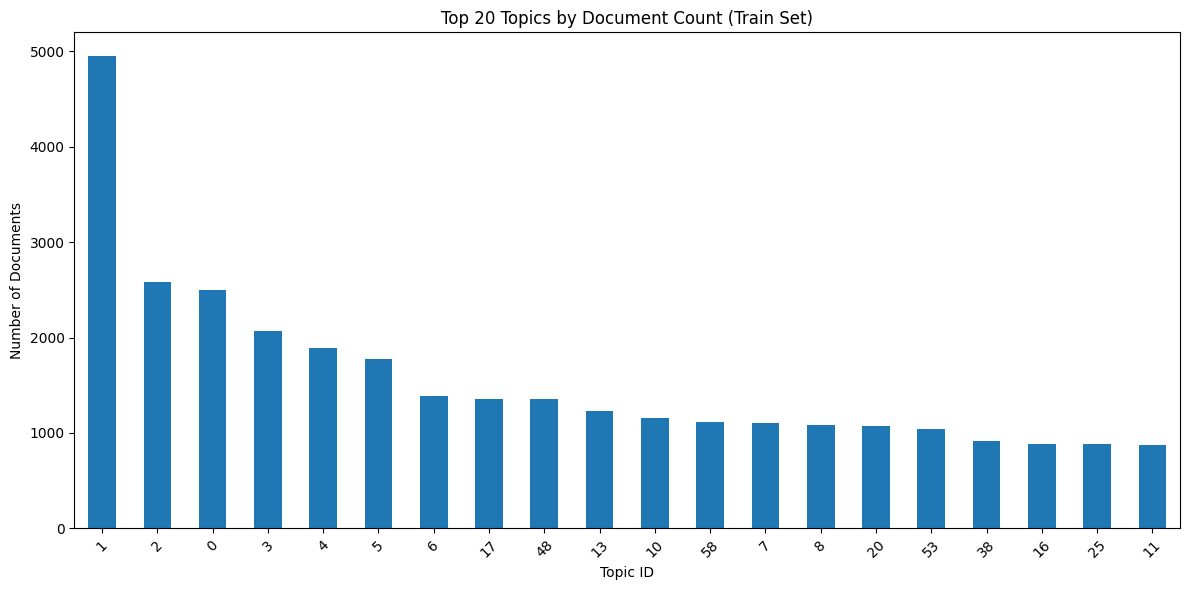

In [43]:
import matplotlib.pyplot as plt

topic_counts = df_train['topic'].value_counts().head(20)
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar')
plt.title('Top 20 Topics by Document Count (Train Set)')
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Save the model for future use: 

In [ ]:
if os.path.exists(model_path):
    print('The model has already been saved!')

else:
    topic_model.save("Bertopic_model_save", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

## Test

Here the code that classyfies the test data into the topics. It also forces to fit outliers

In [45]:
docs_test = df_test['clean_text'].tolist()
topics_test, probs_test = topic_model.transform(docs_test)

print("=" * 80)
print("OUTLIER REDUCTION FOR TEST SET")
print("=" * 80)

print(f"\nInitial number of outliers: {topics_test.count(-1)}")
print(f"Initial number of topics: {len(set(topics_test)) - (1 if -1 in topics_test else 0)}")

print("\nReducing outliers using multiple strategies...")
print("\nStep 1: Using 'c-tf-idf' strategy (fast, good initial reduction)...")
topics_test_reduced = topic_model.reduce_outliers(
    docs_test, 
    topics_test, 
    strategy="c-tf-idf",
    threshold=0.1
)

print(f"After c-tf-idf strategy - Outliers: {topics_test_reduced.count(-1)}")

print("\nStep 2: Using 'probabilities' strategy (for remaining outliers)...")
topics_test_reduced = topic_model.reduce_outliers(
    docs_test, 
    topics_test_reduced, 
    probabilities=probs_test,
    strategy="probabilities",
    threshold=0.05
)

print(f"After probabilities strategy - Outliers: {topics_test_reduced.count(-1)}")

print("\nStep 3: Using 'embeddings' strategy (for final outliers)...")
print("Computing embeddings for outlier reduction...")
embeddings_test_for_reduction = embedding_model.encode(docs_test, show_progress_bar=True, batch_size=32)

topics_test_reduced = topic_model.reduce_outliers(
    docs_test, 
    topics_test_reduced,
    embeddings=embeddings_test_for_reduction,
    strategy="embeddings",
    threshold=0.3
)

final_outliers = topics_test_reduced.count(-1)
final_topics = len(set(topics_test_reduced)) - (1 if -1 in topics_test_reduced else 0)

print(f"\nFinal number of outliers: {final_outliers}")
print(f"Final number of topics: {final_topics}")
print(f"Outliers reduced by: {topics_test.count(-1) - final_outliers} ({((topics_test.count(-1) - final_outliers) / topics_test.count(-1) * 100):.1f}%)")

topics_test = topics_test_reduced
print("\nOutlier reduction for test set completed!")

df_test['topic'] = topics_test

print(f"\nNumber of test documents: {len(docs_test)}")
print(f"Number of unique topics in test set: {final_topics}")
print(f"Number of outliers in test set: {final_outliers}")

print("\nTest set topic distribution:")
test_topic_counts = df_test['topic'].value_counts().sort_index()
print(test_topic_counts.head(20))


Batches: 100%|██████████| 677/677 [00:26<00:00, 25.71it/s]
2026-01-15 18:34:21,577 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2026-01-15 18:34:31,001 - BERTopic - Dimensionality - Completed ✓
2026-01-15 18:34:31,002 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2026-01-15 18:34:33,148 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2026-01-15 18:36:27,717 - BERTopic - Probabilities - Completed ✓
2026-01-15 18:36:27,718 - BERTopic - Cluster - Completed ✓


OUTLIER REDUCTION FOR TEST SET

Initial number of outliers: 13891
Initial number of topics: 328

Reducing outliers using multiple strategies...

Step 1: Using 'c-tf-idf' strategy (fast, good initial reduction)...
After c-tf-idf strategy - Outliers: 389

Step 2: Using 'probabilities' strategy (for remaining outliers)...
After probabilities strategy - Outliers: 109

Step 3: Using 'embeddings' strategy (for final outliers)...
Computing embeddings for outlier reduction...


Batches: 100%|██████████| 677/677 [00:25<00:00, 26.25it/s]



Final number of outliers: 0
Final number of topics: 362
Outliers reduced by: 13891 (100.0%)

Outlier reduction for test set completed!

Number of test documents: 21634
Number of unique topics in test set: 362
Number of outliers in test set: 0

Test set topic distribution:
topic
0     635
1     902
2     599
3     471
4     435
5     408
6     288
7     252
8     214
9     201
10    253
11    197
12    157
13    215
14    159
15    176
16    210
17    260
18    116
19    184
Name: count, dtype: int64


In [46]:
df_test

,link_flair_text,selftext,title,link_flair_text_original,combined_text,clean_text,topic
61277,not a-hole,"I (42F) lived with my husband of 7 months, Rol...",AITA for kicking my son's girlfriend out of my...,Not the A-hole,AITA for kicking my son's girlfriend out of my...,kicking son girlfriend house lazy rude 42 year...,17
56202,not a-hole,"\nFirst off, sorry if my wording is bad my Eng...",AITA for not letting my Mother hold my daughter?,Not the A-hole,AITA for not letting my Mother hold my daughte...,letting mother hold daughter first sorry wordi...,9
46005,a-hole,First off I (42 M) would like to state that I ...,WIBTA - If I reject my sister's request to mak...,Asshole,WIBTA - If I reject my sister's request to mak...,wibta reject sister request make amends first ...,13
95729,not a-hole,"Background: I broke both my feet 5 weeks ago, ...",AITA for asking for help with chores after hav...,Not the A-hole,AITA for asking for help with chores after hav...,asking help chores surgery background broke fe...,252
19551,a-hole,My(17m) twin sister (17f) hates formal dresse...,AITA for chuckling when my sister was complain...,Asshole,AITA for chuckling when my sister was complain...,chuckling sister complaining high heels 17 yea...,43
...,...,...,...,...,...,...,...
7194,a-hole,[removed],AITA for suggesting doing ketamine on 1 year a...,Asshole,AITA for suggesting doing ketamine on 1 year a...,suggesting ketamine 1 year anniversary gf removed,0
62680,not a-hole,This happened a while ago but it has bothered ...,AITA For Not Agreeing to watch my friend's 8 y...,Not the A-hole,AITA For Not Agreeing to watch my friend's 8 y...,agreeing watch friend 8 year old son free work...,29
7813,a-hole,for a little backstory me (22f) and my sister'...,AITA for letting my dad what he wants to eat b...,Asshole,AITA for letting my dad what he wants to eat b...,letting dad wants eat sister let little backst...,34
53479,a-hole,I usually agree with my wife's critiques of th...,AITA for calling my daughter a snitch?,Asshole,AITA for calling my daughter a snitch? I usual...,calling daughter snitch usually agree wife cri...,101


# Cosin similarity

Embedd the texts for cosine similarity measurments:

In [47]:
print("Computing embeddings for train and test documents...")
embeddings_train = embedding_model.encode(docs_train, show_progress_bar=True, batch_size=32)
embeddings_test = embedding_model.encode(docs_test, show_progress_bar=True, batch_size=32)

print(f"Train embeddings shape: {embeddings_train.shape}")
print(f"Test embeddings shape: {embeddings_test.shape}")


Computing embeddings for train and test documents...


Batches: 100%|██████████| 677/677 [00:26<00:00, 26.02it/s]


Train embeddings shape: (86534, 384)
Test embeddings shape: (21634, 384)


## Calculating

Function that takes the data from the same topic and runs cosine similarity evaluation. Then it takes its wighted average. `k` is the number of top values

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

def predict_link_flair_weighted(test_idx, k=10):
    """
    Predict link_flair_text for a test sample using weighted cosine similarity.
    
    Args:
        test_idx: Index of test sample in df_test
        k: Number of most similar documents to consider
    
    Returns:
        Predicted link_flair_text
    """
    test_topic = df_test.iloc[test_idx]['topic']
    test_embedding = embeddings_test[test_idx].reshape(1, -1)
    
    if test_topic == -1:
        train_mask = np.ones(len(df_train), dtype=bool)
    else:
        train_mask = df_train['topic'] == test_topic
    
    if train_mask.sum() == 0:
        train_mask = np.ones(len(df_train), dtype=bool)
    
    train_indices = np.where(train_mask)[0]
    train_embeddings_subset = embeddings_train[train_indices]
    
    similarities = cosine_similarity(test_embedding, train_embeddings_subset)[0]
    
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    top_k_train_indices = train_indices[top_k_indices]
    top_k_similarities = similarities[top_k_indices]
    
    top_k_link_flairs = df_train.iloc[top_k_train_indices]['link_flair_text'].values
    
    flair_weights = {}
    for flair, sim in zip(top_k_link_flairs, top_k_similarities):
        if pd.notna(flair):
            if flair not in flair_weights:
                flair_weights[flair] = 0
            flair_weights[flair] += sim
    
    if not flair_weights:
        return None
    
    predicted_flair = max(flair_weights.items(), key=lambda x: x[1])[0]
    return predicted_flair

print("Predicting link_flair_text for test samples...")
predicted_flairs = []
for i in range(len(df_test)):
    if i % 500 == 0:
        print(f"Processing test sample {i}/{len(df_test)}")
    pred = predict_link_flair_weighted(i, k=5)
    predicted_flairs.append(pred)

df_test['predicted_link_flair_text'] = predicted_flairs
print("\nPrediction completed!")


Predicting link_flair_text for test samples...
Processing test sample 0/21634
Processing test sample 500/21634
Processing test sample 1000/21634
Processing test sample 1500/21634
Processing test sample 2000/21634
Processing test sample 2500/21634
Processing test sample 3000/21634
Processing test sample 3500/21634
Processing test sample 4000/21634
Processing test sample 4500/21634
Processing test sample 5000/21634
Processing test sample 5500/21634
Processing test sample 6000/21634
Processing test sample 6500/21634
Processing test sample 7000/21634
Processing test sample 7500/21634
Processing test sample 8000/21634
Processing test sample 8500/21634
Processing test sample 9000/21634
Processing test sample 9500/21634
Processing test sample 10000/21634
Processing test sample 10500/21634
Processing test sample 11000/21634
Processing test sample 11500/21634
Processing test sample 12000/21634
Processing test sample 12500/21634
Processing test sample 13000/21634
Processing test sample 13500/216

## Results

Accuracy: 0.5611

Classification Report:
              precision    recall  f1-score   support

      a-hole       0.57      0.50      0.53     10817
  not a-hole       0.55      0.63      0.59     10817

    accuracy                           0.56     21634
   macro avg       0.56      0.56      0.56     21634
weighted avg       0.56      0.56      0.56     21634


Confusion Matrix:


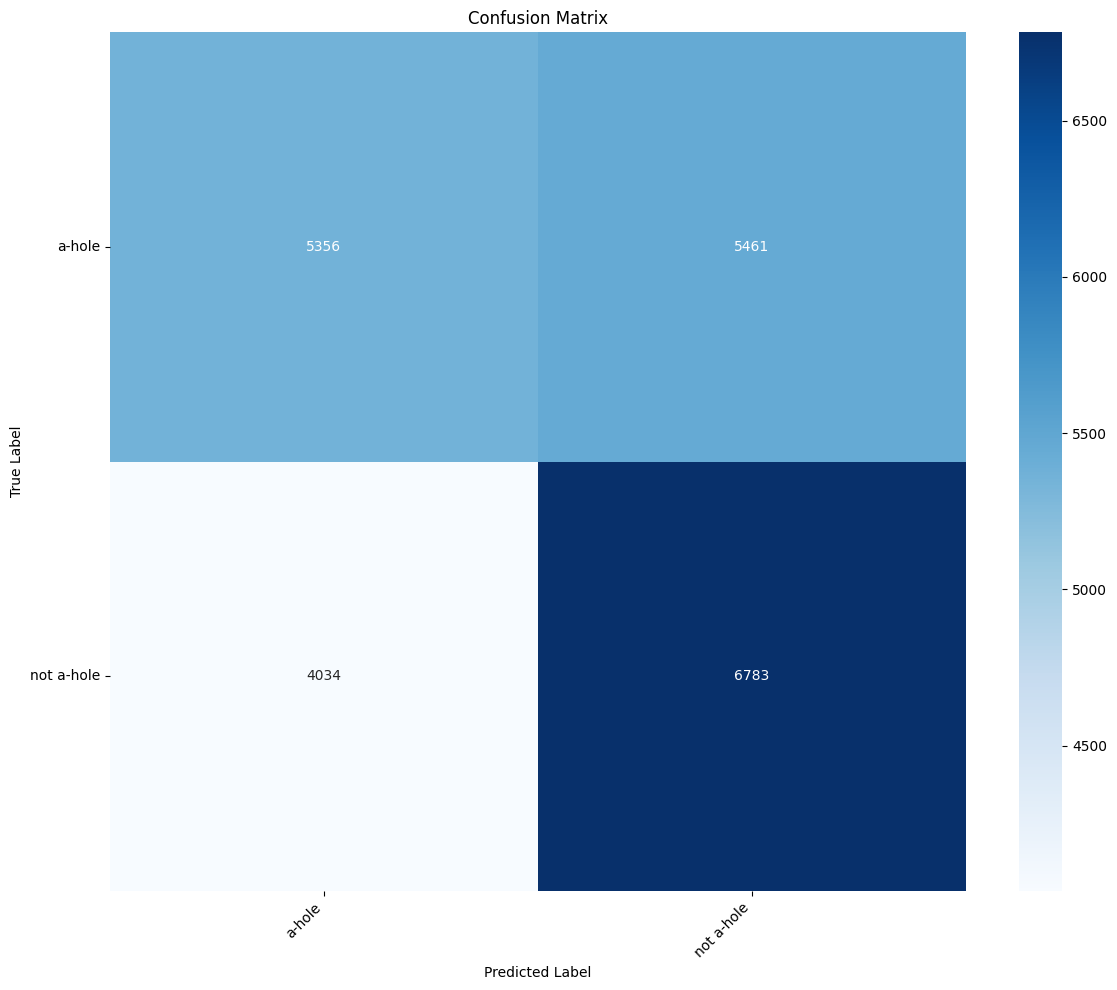


Total test samples: 21634
Valid predictions: 21634
Samples with missing predictions: 0


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

df_test_eval = df_test.dropna(subset=['link_flair_text', 'predicted_link_flair_text'])

if len(df_test_eval) > 0:
    y_true = df_test_eval['link_flair_text']
    y_pred = df_test_eval['predicted_link_flair_text']
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true) | set(y_pred)))
    labels = sorted(set(y_true) | set(y_pred))
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal test samples: {len(df_test)}")
    print(f"Valid predictions: {len(df_test_eval)}")
    print(f"Samples with missing predictions: {len(df_test) - len(df_test_eval)}")
else:
    print("No valid predictions to evaluate.")


In [1]:
df_test_eval = df_test.dropna(subset=['link_flair_text', 'predicted_link_flair_text'])
df_test_eval['correct'] = df_test_eval['link_flair_text'] == df_test_eval['predicted_link_flair_text']

print("=" * 80)
print("EXAMPLES OF CORRECT PREDICTIONS")
print("=" * 80)
correct_examples = df_test_eval[df_test_eval['correct']].head(5)
for idx, row in correct_examples.iterrows():
    print(f"\nTrue Label: {row['link_flair_text']}")
    print(f"Predicted Label: {row['predicted_link_flair_text']}")
    print(f"Topic: {row['topic']}")
    print(f"Title: {row['title'][:100]}...")
    print("-" * 80)

print("\n" + "=" * 80)
print("EXAMPLES OF INCORRECT PREDICTIONS")
print("=" * 80)
incorrect_examples = df_test_eval[~df_test_eval['correct']].head(5)
for idx, row in incorrect_examples.iterrows():
    print(f"\nTrue Label: {row['link_flair_text']}")
    print(f"Predicted Label: {row['predicted_link_flair_text']}")
    print(f"Topic: {row['topic']}")
    print(f"Title: {row['title'][:100]}...")
    print("-" * 80)


NameError: name 'df_test' is not defined